## Initialization

In [ ]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join('..')))
import torch
from kar_hnn import KARHNN
from data import get_dataset

## Help Functions

In [56]:
# print squared loss at specific steps for comparison with HNN
print_every = 200
def print_results(results, print_every=200):
    for step in range(0, len(results["train_loss"]), print_every):
        print(
            "step {}, train_loss {:.4e}, test_loss {:.4e}".format(
                step,
                results["train_loss"][step],
                results["test_loss"][step],
            )
        )

## Create Dataset

In [57]:
# create dataset
data = get_dataset(seed=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.tensor(data["x"], requires_grad=True, dtype=torch.float32).to(device)
test_x = torch.tensor(data["test_x"], requires_grad=True, dtype=torch.float32).to(device)
dxdt = torch.Tensor(data["dx"]).to(device)
test_dxdt = torch.Tensor(data["test_dx"]).to(device)

# dataset['train_input'], dataset['train_label'],dataset['test_input'], dataset['test_label']
dataset = {
    "train_input": x,
    "train_label": dxdt,
    "test_input": test_x,
    "test_label": test_dxdt,
}

In [58]:
dataset["train_input"].shape, dataset["train_label"].shape

(torch.Size([1125, 2]), torch.Size([1125, 2]))

## Model Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# initialize KAN with G=3
model = KARHNN(input_dim=2, width=[2, 2, 2], grid=2, k=3, seed=1, device=device)
results = model.fit(dataset, opt="LBFGS", steps=300, log=1)
print_results(results, 10)

cpu
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                          | 0/300 [00:00<?, ?it/s]

| train_loss: 3.27e-02 | test_loss: 3.43e-02 | reg: 1.19e+01 | : 100%|█| 300/300 [00:28<00:00, 10.38

saving model version 0.1
step 0, train_loss 2.2177e-01, test_loss 2.4829e-01
step 10, train_loss 3.4637e-02, test_loss 3.8893e-02
step 20, train_loss 3.3157e-02, test_loss 3.4565e-02
step 30, train_loss 3.2971e-02, test_loss 3.4654e-02
step 40, train_loss 3.2893e-02, test_loss 3.4364e-02
step 50, train_loss 3.2837e-02, test_loss 3.4368e-02
step 60, train_loss 3.2811e-02, test_loss 3.4330e-02
step 70, train_loss 3.2793e-02, test_loss 3.4380e-02
step 80, train_loss 3.2788e-02, test_loss 3.4383e-02
step 90, train_loss 3.2778e-02, test_loss 3.4383e-02
step 100, train_loss 3.2776e-02, test_loss 3.4366e-02
step 110, train_loss 3.2770e-02, test_loss 3.4358e-02
step 120, train_loss 3.2763e-02, test_loss 3.4375e-02
step 130, train_loss 3.2762e-02, test_loss 3.4364e-02
step 140, train_loss 3.2762e-02, test_loss 3.4355e-02
step 150, train_loss 3.2761e-02, test_loss 3.4353e-02
step 160, train_loss 3.2759e-02, test_loss 3.4366e-02
step 170, train_loss 3.2744e-02, test_loss 3.4340e-02
step 180, trai

[tensor([1.2503, 0.6421], grad_fn=<MeanBackward1>), tensor([0.5488, 0.5079], grad_fn=<MeanBackward1>), tensor([0.5000, 0.5000], grad_fn=<MeanBackward1>)]


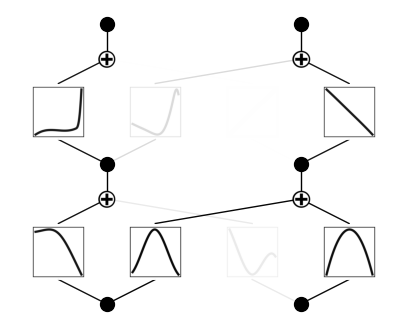

In [60]:
model.attribute()
print(model.node_scores)
model.plot()

saving model version 0.2


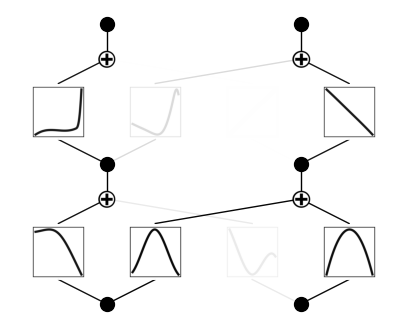

In [61]:
model = model.prune_node(threshold=1e-1)
model.plot()

fixing (0,0,0) with cos, r2=0.9976139664649963, c=2
fixing (0,0,1) with cos, r2=0.999778151512146, c=2
fixing (0,1,0) with x, r2=0.07859457284212112, c=1
fixing (0,1,1) with x^2, r2=1.0000001192092896, c=2
fixing (1,0,0) with x, r2=0.4421333074569702, c=1
fixing (1,0,1) with x, r2=0.7356400489807129, c=1
fixing (1,1,0) with x, r2=0.9999819397926331, c=1
fixing (1,1,1) with x, r2=0.9999580383300781, c=1
saving model version 0.3


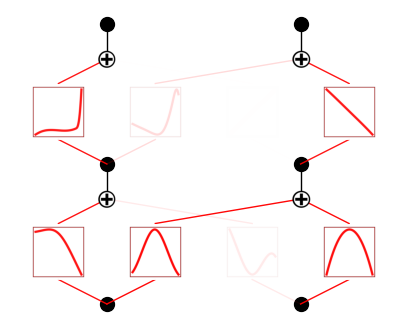

In [62]:
mode = "auto"  # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0, 0, 0, "x^2")
    model.fix_symbolic(0, 1, 0, "x^2")
    model.fix_symbolic(1, 0, 0, "x")
    model.fix_symbolic(1, 0, 1, "x")
elif mode == "auto":
    # automatic mode
    lib = ["x", "x^2", "x^3", "x^4", "sqrt", "tanh", "sin", 'cos', "abs"]
    model.auto_symbolic(lib=lib)
model.plot()

In [63]:
from kan.utils import ex_round

[ex_round(y, 4) for y in model.symbolic_formula()[0]]

[-0.1609*x_2**2 - 0.3773*x_2 - 343.1605*cos(0.2144*x_1 + 3.4234) - 0.4897*cos(1.0021*x_1 + 3.197) - 271.9019,
 0.9949*x_2**2 + 0.0021*x_2 - 1.0393*cos(0.2144*x_1 + 3.4234) + 3.0274*cos(1.0021*x_1 + 3.197) - 11.6885]

![hnn](./hnn.png)
![baseline](./baseline.png)
